# Анализ социально-экономических факторов на уровень счастья и удовлетворенности жизнью в странах Европы

## **1. Сбор данных**

Описание признаков: [ссылка](https://docs.google.com/document/d/16r0fiIdUSfEgPYzUKSXar4MYbYAaMIZl/edit)

Датасет в формате csv: [ссылка](https://drive.google.com/file/d/1ZFxt4HygAkduFb7HVVI3ZcIyf51oIXCA/view?usp=share_link)

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [236]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [237]:
data = pd.read_csv('final_dataset.csv')

In [238]:
data.head()

,Unnamed: 0,idno,agea,rlgdgr,polintr,sclmeet,happy,cntry,netustm,nwspol,...,actrolga,cptppola,trstprl,trstlgl,trstplc,trstplt,vote,stfeco,stfdem,stfedu
0,0,50014,65,5,1,4,8,AT,180,90,...,5,5,6,9,10,5,1,6,6,8
1,1,50030,21,0,2,7,9,AT,570,90,...,2,2,6,6,4,1,1,2,7,10
2,2,50057,53,8,2,4,9,AT,30,30,...,4,3,7,5,8,4,1,6,6,5
3,3,50106,78,6,3,6,7,AT,6666,15,...,2,3,5,6,9,3,2,4,6,5
4,4,50145,64,1,2,5,9,AT,120,60,...,1,3,6,8,8,5,1,6,8,9


In [239]:
data = data.drop('Unnamed: 0', axis=1)

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40156 entries, 0 to 40155
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idno       40156 non-null  int64 
 1   agea       40156 non-null  int64 
 2   rlgdgr     40156 non-null  int64 
 3   polintr    40156 non-null  int64 
 4   sclmeet    40156 non-null  int64 
 5   happy      40156 non-null  int64 
 6   cntry      40156 non-null  object
 7   netustm    40156 non-null  int64 
 8   nwspol     40156 non-null  int64 
 9   pplfair    40156 non-null  int64 
 10  health     40156 non-null  int64 
 11  sclmeet.1  40156 non-null  int64 
 12  atchctr    40156 non-null  int64 
 13  aesfdrk    40156 non-null  int64 
 14  dscrgrp    40156 non-null  int64 
 15  pray       40156 non-null  int64 
 16  hhmmb      40156 non-null  int64 
 17  gndr       40156 non-null  int64 
 18  yrbrn      40156 non-null  int64 
 19  impdiffa   40156 non-null  int64 
 20  impfuna    40156 non-null  i

In [241]:
data.describe()

,idno,agea,rlgdgr,polintr,sclmeet,happy,netustm,nwspol,pplfair,health,...,actrolga,cptppola,trstprl,trstlgl,trstplc,trstplt,vote,stfeco,stfdem,stfedu
count,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,...,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000
mean,69002.327996,58.062705,5.296344,2.632683,4.940557,7.741433,1658.262700,207.197779,6.131985,2.153775,...,2.211401,2.289048,6.204627,7.045821,7.221561,4.945413,1.381886,5.935228,7.749278,8.796892
std,11212.160887,79.637641,6.955249,0.960560,3.777767,4.773365,2705.045954,1009.336526,6.276457,0.928276,...,1.275698,1.270549,11.652521,11.209156,7.636108,10.279775,0.841324,10.759571,14.406229,16.685319
min,50002.000000,15.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,59407.000000,37.000000,2.000000,2.000000,4.000000,7.000000,120.000000,30.000000,4.000000,1.000000,...,1.000000,1.000000,3.000000,4.000000,5.000000,2.000000,1.000000,3.000000,3.000000,4.000000
50%,68818.000000,53.000000,5.000000,3.000000,5.000000,8.000000,240.000000,60.000000,6.000000,2.000000,...,2.000000,2.000000,5.000000,6.000000,7.000000,4.000000,1.000000,5.000000,5.000000,6.000000
75%,78245.250000,67.000000,7.000000,3.000000,6.000000,9.000000,600.000000,120.000000,7.000000,3.000000,...,3.000000,3.000000,7.000000,8.000000,8.000000,6.000000,2.000000,6.000000,7.000000,7.000000
max,99403.000000,999.000000,99.000000,9.000000,99.000000,99.000000,9999.000000,9999.000000,99.000000,9.000000,...,9.000000,9.000000,99.000000,99.000000,99.000000,99.000000,9.000000,99.000000,99.000000,99.000000


In [242]:
data.describe(include='object')

,cntry
count,40156
unique,24
top,IT
freq,2865


In [243]:
data['cntry'].value_counts()

cntry
IT    2865
GR    2757
DE    2420
AT    2354
HU    2118
IE    2017
ES    1844
FR    1771
NL    1695
GB    1684
BE    1594
FI    1563
RS    1563
HR    1563
SK    1442
PL    1442
CH    1384
PT    1373
LT    1365
NO    1337
SI    1248
SE    1230
IS     842
CY     685
Name: count, dtype: int64

# Предобработка данных

In [244]:
features = data.columns.to_list()[23:34]
features.append('happy')
print(f"Признаки для обработки {features}")
df_feat = data[features]

Признаки для обработки ['ipsucesa', 'enjlf', 'fltdpr', 'fltlnl', 'slprl', 'dosprt', 'cgtsmok', 'alcfreq', 'height', 'weighta', 'fnsdfml', 'happy']


ipsucesa - важно быть успешным и признания достижений другими людьми
enjlf -  наслаждались жизнью, как часто за прошлую неделю
fltdpr - чувствовали себя одиноким, как часто за прошлую неделю
fltlnl - сколько времени за прошлую неделю вы чувствовали себя одиноким
slprl -  как часто за прошлую неделю сон был беспокойным,
dosprt - занимались ли вы спортом или другой физической активностью, сколько из последних 7 дней
cgtsmok  - отношение к курению
alcfreq - как часто вы принимали алкоголь за последний год
height - рост респондента
weighta - вес респондента
fnsdfml - как часто были серьезные конфликты между членами семьи в период взросления

In [245]:
df_feat.describe()

,ipsucesa,enjlf,fltdpr,fltlnl,slprl,dosprt,cgtsmok,alcfreq,height,weighta,fnsdfml,happy
count,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000,40156.000000
mean,4.727164,2.928080,1.452162,1.443819,1.790119,4.123319,4.464513,4.927458,190.515440,115.954154,3.764618,7.741433
std,11.107167,0.923338,0.763980,0.804517,0.895194,8.913957,1.787270,5.546143,121.063062,178.606161,1.234493,4.773365
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,106.000000,30.000000,1.000000,0.000000
25%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,165.000000,65.000000,3.000000,7.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,170.000000,75.000000,4.000000,8.000000
75%,4.000000,4.000000,2.000000,2.000000,2.000000,6.000000,6.000000,7.000000,178.000000,87.000000,5.000000,9.000000
max,99.000000,9.000000,9.000000,9.000000,9.000000,99.000000,9.000000,99.000000,999.000000,999.000000,9.000000,99.000000


Из представленных к предобработке данных 10 признаков из них 7 порядковые категориальные и 3 числовых дискретных: 'dosprt', 'height', 'weighta' (данные о количестве дней занятий спортом в неделю, рост и вес соответственно). 

В данных присутсвуют такие значения как, 7 - Refusal, 8 - Don't know, 9 - No answer, 66 - Not applicable, 77 - Refusal, 88 - Don't know, 99 - No answer* . Их заменим пустыми значениями. Числовые и категориальные признаки обработаем отдельно.

In [246]:
# замена бинарных значений

data['dscrgrp'] = data['dscrgrp'].replace({2: 0})
data['gndr'] = data['gndr'].replace({2: 0})

# замена значений: (как выражены отсуствующие значения): [названия столбцов]
# idno, сntry, paccnt, uempla - нет пропущенных значений

replacement_dict = {
    (6, 7, 8, 9): ['emplrel', 'uemp12m', 'eisced'],
    (7, 8, 9): ['health', 'aesfdrk', 'dscrgrp', 'gndr', 'polintr', 'cptppola', 'vote', 'fnsdfml', 'actrolga', 'cnfpplh', 'hincfel', 'cgtsmok', 'enjlf', 'fltdpr', 'fltlnl',  'slprl'],
    (66, 77, 88, 99): ['happy', 'marsts', 'eisced',
                       'alcfreq', 'ipsucesa', 'dosprt',
                       'impsafea', 'iphlppla',
                       'atchctr', 'pray', 'hhmmb', 'impdiffa', 'impfuna',
                       'pplfair', 'happy', 'sclmeet', 'rlgdgr',
                       'trstprl', 'trstlgl', 'trstplc', 'trstplt', 'stfeco', 'stfdem', 'stfedu'],
    (777, 888, 999): ['agea', 'weighta', 'height'],
    (6666, 7777, 8888, 9999): ['yrbrn', 'netustm', 'nwspol']
    }



In [247]:
 # заменяем значения выше на nan чтобы дальше было удобнее работать с ними

for values, columns in replacement_dict.items():
  for i in columns:
    data.loc[:, i] = data[i].replace(values, np.nan)

In [248]:
# считаем кол-во пропущенных значений по столбцам
missing_counts = {col: data[col].isnull().sum() for columns in replacement_dict.values() for col in columns if col in data.columns}

columns_with_high_missing = []

print("Количество пропущенных значений:")
for col, count in missing_counts.items():
    share = round((count / len(data) * 100),2)
    print(f"{col}: {count}, доля от всех данных: {share}%")
    if share > 20:
            columns_with_high_missing.append(col)

print(f"\nСтолбцы с долей пропущенных значений больше 20%:{columns_with_high_missing}")




Количество пропущенных значений:
emplrel: 3944, доля от всех данных: 9.82%
uemp12m: 29866, доля от всех данных: 74.37%
eisced: 10874, доля от всех данных: 27.08%
health: 53, доля от всех данных: 0.13%
aesfdrk: 295, доля от всех данных: 0.73%
dscrgrp: 270, доля от всех данных: 0.67%
gndr: 0, доля от всех данных: 0.0%
polintr: 56, доля от всех данных: 0.14%
cptppola: 579, доля от всех данных: 1.44%
vote: 360, доля от всех данных: 0.9%
fnsdfml: 557, доля от всех данных: 1.39%
actrolga: 597, доля от всех данных: 1.49%
cnfpplh: 428, доля от всех данных: 1.07%
hincfel: 451, доля от всех данных: 1.12%
cgtsmok: 81, доля от всех данных: 0.2%
enjlf: 278, доля от всех данных: 0.69%
fltdpr: 175, доля от всех данных: 0.44%
fltlnl: 173, доля от всех данных: 0.43%
slprl: 139, доля от всех данных: 0.35%
happy: 132, доля от всех данных: 0.33%
marsts: 19548, доля от всех данных: 48.68%
alcfreq: 179, доля от всех данных: 0.45%
ipsucesa: 773, доля от всех данных: 1.92%
dosprt: 438, доля от всех данных: 1.

In [249]:
data_20 = data.drop(columns_with_high_missing, axis=1)

In [250]:
data_20=data_20.dropna()

In [251]:
data_20.shape

(28318, 48)

In [252]:
df_feat = data_20[features]
df_feat.describe()

,ipsucesa,enjlf,fltdpr,fltlnl,slprl,dosprt,cgtsmok,alcfreq,height,weighta,fnsdfml,happy
count,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000,28318.000000
mean,3.212480,2.948301,1.395014,1.367152,1.760647,3.375521,4.382054,4.370930,171.524861,76.607317,3.739636,7.613214
std,1.361601,0.811079,0.623304,0.649233,0.819770,2.578490,1.774416,1.994463,9.455191,15.022603,1.132799,1.685987
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,130.000000,37.000000,1.000000,0.000000
25%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,165.000000,65.000000,3.000000,7.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,5.000000,4.000000,171.000000,75.000000,4.000000,8.000000
75%,4.000000,4.000000,2.000000,2.000000,2.000000,6.000000,6.000000,6.000000,178.000000,86.000000,5.000000,9.000000
max,6.000000,4.000000,4.000000,4.000000,4.000000,7.000000,6.000000,7.000000,207.000000,148.000000,5.000000,10.000000


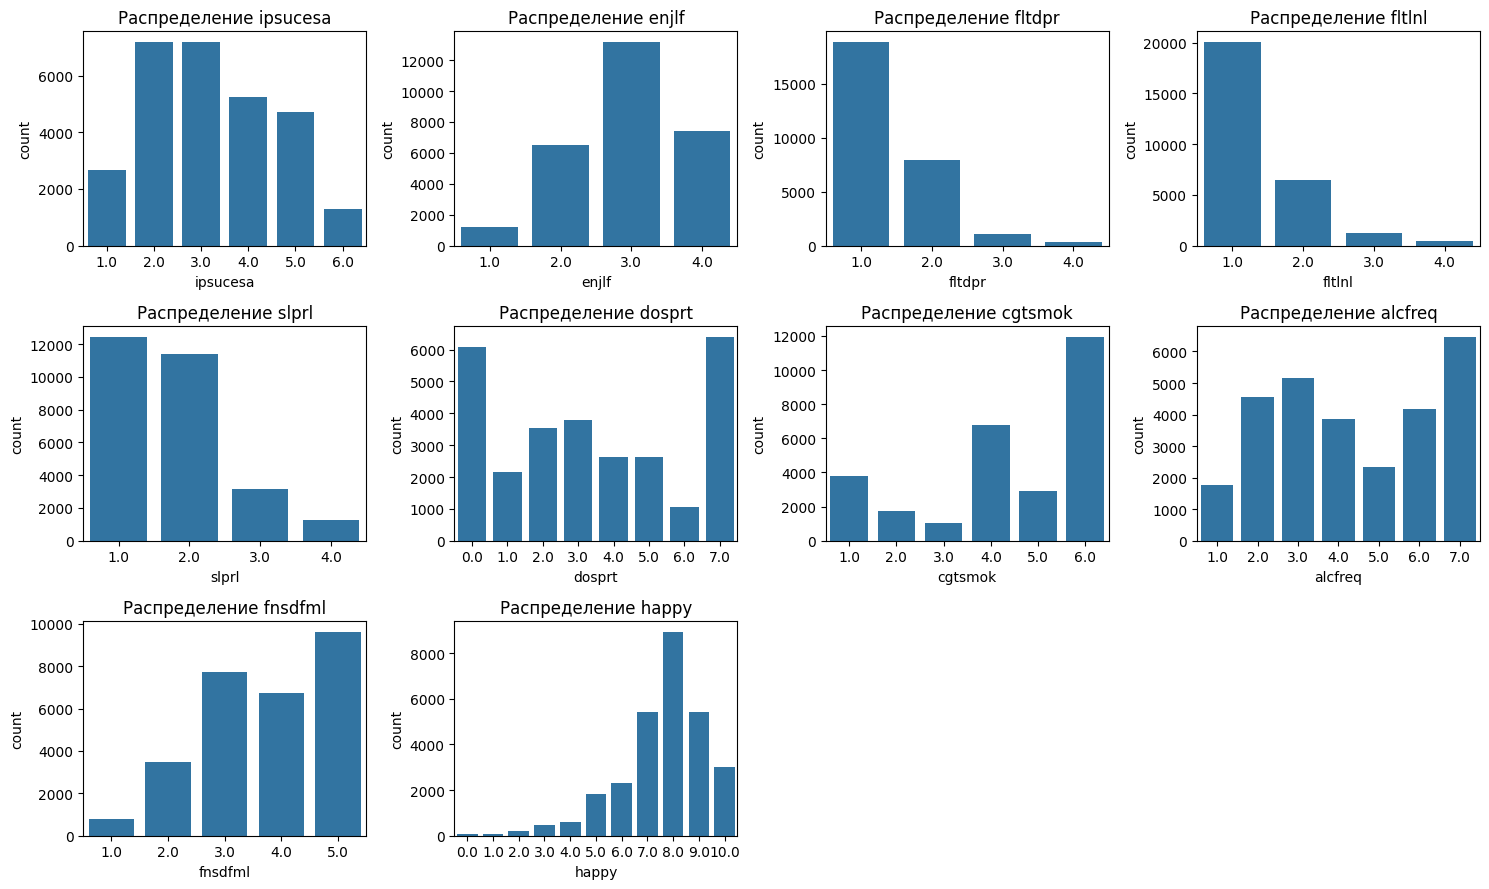

In [253]:
columns_countplot = df_feat.drop(columns=['weighta','height'])
num_columns = len(columns_countplot.columns)

nrows = int(np.ceil(num_columns / 4)) 
ncols = min(num_columns, 4)

plt.figure(figsize=(15, nrows * 3)) 

for i, column in enumerate(columns_countplot.columns, 1):
    plt.subplot(nrows, ncols, i)
    sns.countplot(x=column, data=data_20)
    plt.title(f'Распределение {column}')

plt.tight_layout()
plt.show()

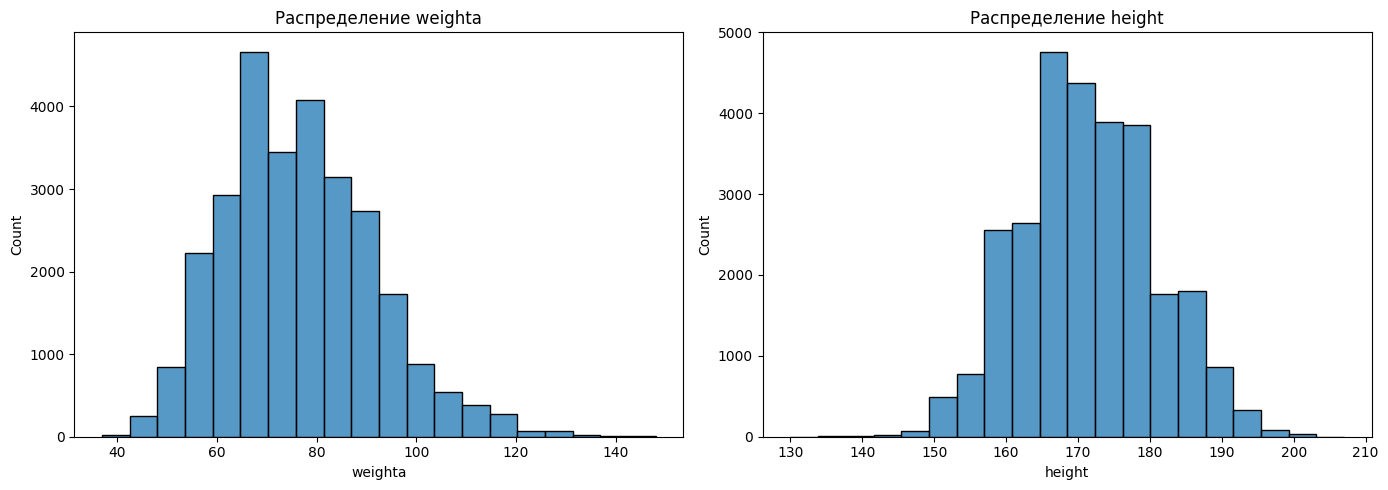

In [254]:
plt.figure(figsize=(14, 5)) 

for i, column in enumerate(df_feat[['weighta','height']], 1):
    plt.subplot(1, 2, i)
    sns.histplot(x=column, data=data_20, bins=20)
    plt.title(f'Распределение {column}')

plt.tight_layout()
plt.show()

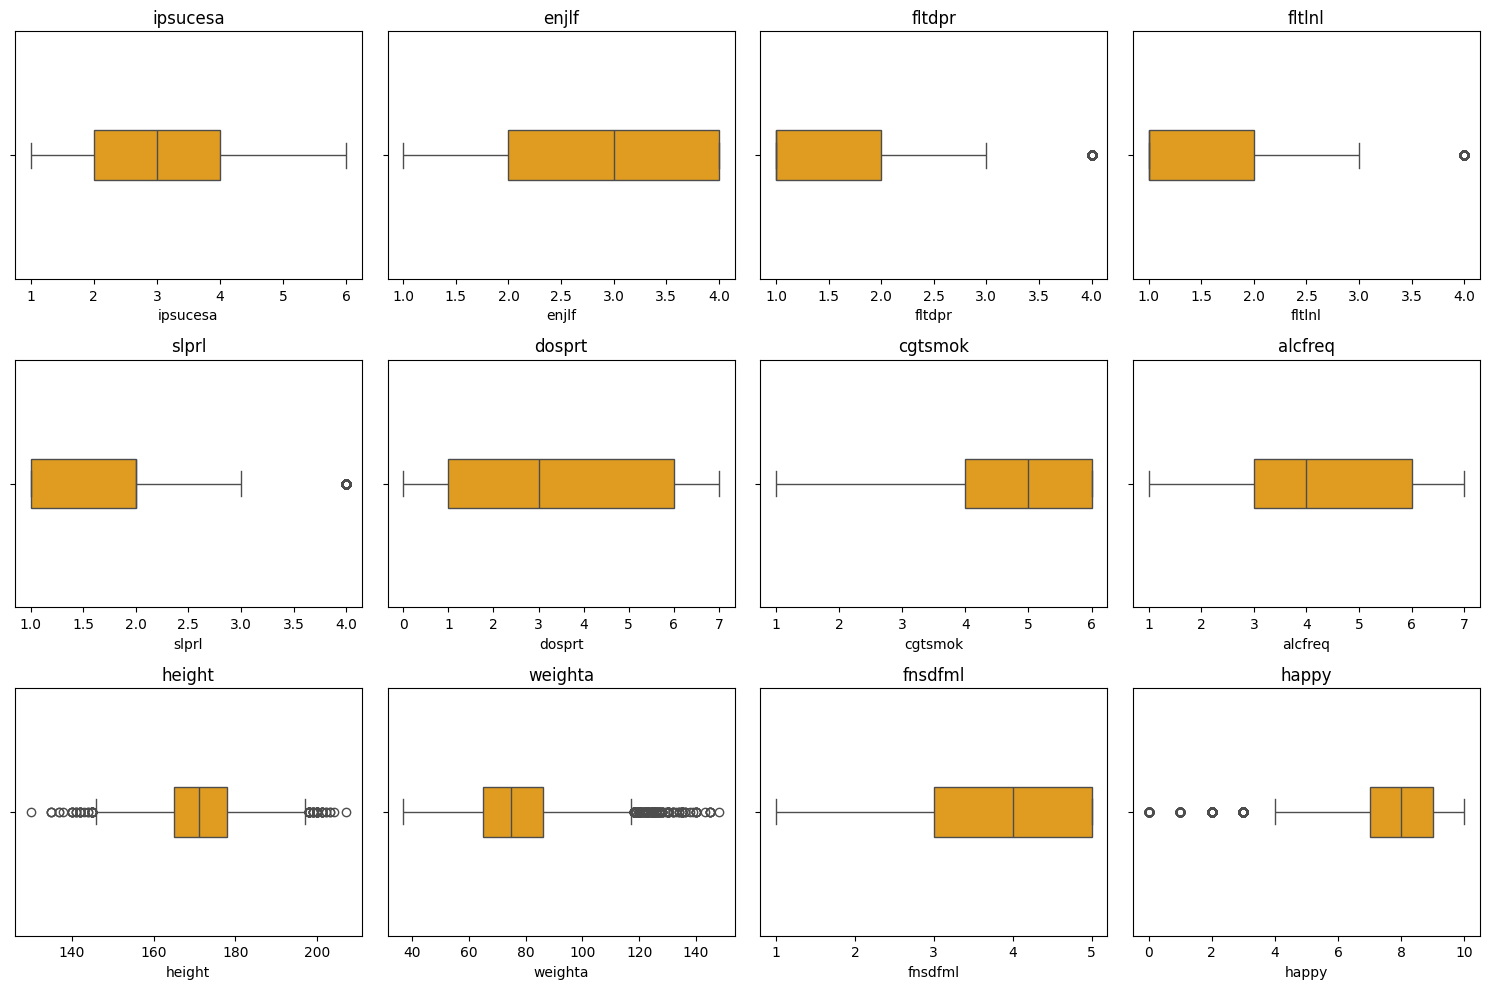

In [255]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_feat.columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df_feat[column], width=0.2, color = 'orange')
    plt.title(column)

plt.tight_layout()
plt.show()

- ipsucesa - большинство ответило, что признание успеха важно для них, это 2 и  медиана  - 3, где 1-очень похоже на меня, 2-похоже на меня, 3-отчасти похоже на меня, 4-немного похоже на меня, 5-Не похоже на меня, 6-совсем не похоже на меня.

- enjlf -  большинство респондентов отчетили, что за прошлую неделю чувствовали себя счастливыми большую часть времени -3, где 1 - никогда или почти никогда, 2 - иногда, 3 - большую часть времени, 4 - всегда или почти всегда.

- fltdpr - большинство не чувствовали себя одинокими за прошлую неделю, где 1 - никогда или почти никогда, 2 - иногда, 3 - большую часть времени, 4 - всегда или почти всегда.

- fltlnl - на вопрос: как часто за прошлую неделю вы чувствовали себя одиноким, где 1 - никогда или почти никогда, 2 - иногда, 3 - большую часть времени, 4 - всегда или почти всегда, большиноство ответили никогда или иногда.

- slprl -  на вопрос как часто за прошлую неделю сон был беспокойным большинство ответило никогда или иногда, где 1 - никогда или почти никогда, 2 - иногда, 3 - большую часть времени, 4 - всегда или почти всегда.

- dosprt - занимались ли вы спортом или другой физической активностью, сколько из последних 7 дней. Здесь мнения разделились, примерно одинаковое количество занимается спортом каждый день в неделю и не занимается спортом.

- cgtsmok  - отношение к курению, где 1 - я курю ежедневно 10 или более сигарет, 2 - я курю ежедневно 9 или меньше сигарет, 3 - я курю, но не каждый день, 4 - я не курю сейчас, но раньше курил(а), 5 - я курил(а) всего несколько раз, 6 - я никогда не курил(а). Большинство респондентов не курящие.


- alcfreq - как часто вы принимали алкоголь за последний год, где  1 - каждый день, 2 - несколько раз в неделю, 3 - один раз в неделю, 4 - 2-3 раза в месяц, 5 - один раз в месяц, 6 - реже одного раза в месяц, 7 - никогда. В целом, большая часть употребляет алкоголь не чаще несколько раз в неделю, медианное значение 2-3 раза в месяц.

- height - рост респондента, средний рост  - 171 см, совпадает с медианным значением, стандартное отклонение - 9 см. Присутствуют выбросы.

- weighta - вес респондента, средний вес - 76 кг, медианное значение - 75 кг, стандартное отклонение  - 15,6 кг. Присутствуют выбросы.

- fnsdfml - как часто были серьезные конфликты между членами семьи в период взросления, где 1 - всегда, 2 - часто, 3 - иногда, 4 - почти никогда, 5 - никогда. У большинства конфликтов в детстве не было.

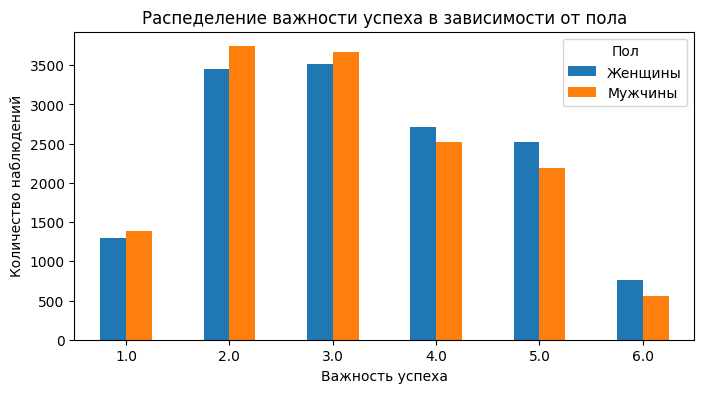

In [256]:
data_20.pivot_table(index='ipsucesa', columns='gndr', values='idno', aggfunc='count').plot(kind='bar', figsize=(8, 4))
plt.title("Распеделение важности успеха в зависимости от пола")
plt.xlabel("Важность успеха")
plt.ylabel("Количество наблюдений")
plt.legend(title='Пол', labels=['Женщины', 'Мужчины'])
plt.xticks(rotation = 0)
plt.show()

Как видно из графика, где 1 и 2  говорят о важности признания успеха,то для доля мужчин больше, чем женщин.

Рассмотрим признак enjlf. Разделим респондентов на две группы 0 - это те, кто ответил, что не чувствовали себя себя счастливыми за прошлую неделю никогда или иногда, и 1 - те, кто были чувствовали себя счастливыми всегда или почти всегда. 

In [274]:
# приводим к бинарному признаку
data_20['enjlf_cat'] = data_20['enjlf'].apply(lambda x: 0 if x in [1,2] else 1)

# создадим сводную таблицу по странам
data_enjlf = data_20.pivot_table(index='cntry', columns='enjlf_cat', values='idno', aggfunc='count').reset_index()

# найдем долю счастливых людей
data_enjlf['sum'] = data_enjlf.iloc[:, 1:3].sum(axis=1)
data_enjlf['percent_of_happy'] = round(data_enjlf[1] / data_enjlf['sum']*100,2)
data_enjlf

enjlf_cat,cntry,0,1,sum,percent_of_happy
0,AT,552,1095,1647,66.48
1,BE,213,1028,1241,82.84
2,CH,174,827,1001,82.62
3,CY,160,305,465,65.59
4,DE,606,1386,1992,69.58
5,ES,418,991,1409,70.33
6,FI,328,1021,1349,75.69
7,FR,178,1131,1309,86.40
8,GB,192,744,936,79.49
9,GR,661,1125,1786,62.99


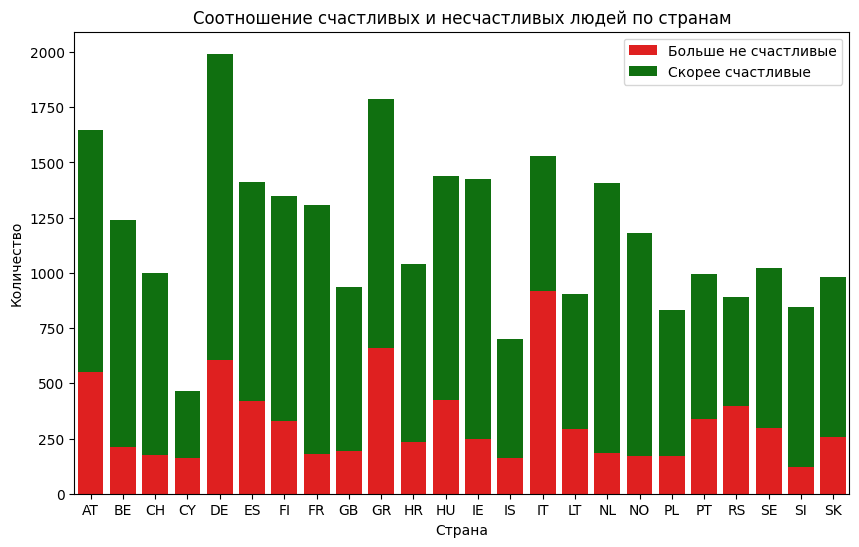

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(x='cntry', y=0, data=data_enjlf, color='red', label='Больше не счастливые')
sns.barplot(x='cntry', y=1, data=data_enjlf, color='green', label='Скорее счастливые', bottom=data_enjlf[0])

plt.title('Соотношение счастливых и несчастливых людей по странам')
plt.xlabel('Страна')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [260]:
top_5 = data_enjlf[['cntry', 'percent_of_happy']].sort_values('percent_of_happy', ascending=False)[:5]
print('Топ 5 стран по наибольшему проценту счастливых резидентов по оценке за неделю в стране')
print(top_5)

Топ 5 стран по наибольшему проценту счастливых резидентов по оценке за неделю в стране
enjlf_cat cntry  percent_of_happy
16           NL             86.90
7            FR             86.40
22           SI             85.66
17           NO             85.58
1            BE             82.84


Cоставим сводную таблицу для ответов на вопросы:
- 1) чувствовали вы себя на прошлой неделе одинокими fltdpr, 
- 2) сколько времени вы чувствовали себя одинокими на прошлой неделе.

In [261]:
pivot_data = data_20.pivot_table(index='fltdpr', columns='fltlnl', values='idno', aggfunc='count')
pivot_data

fltlnl,1.0,2.0,3.0,4.0
fltdpr,,,,
1.0,15691,2853,256,115
2.0,3997,3206,604,147
3.0,326,367,292,130
4.0,103,61,80,90


<Figure size 1000x600 with 0 Axes>

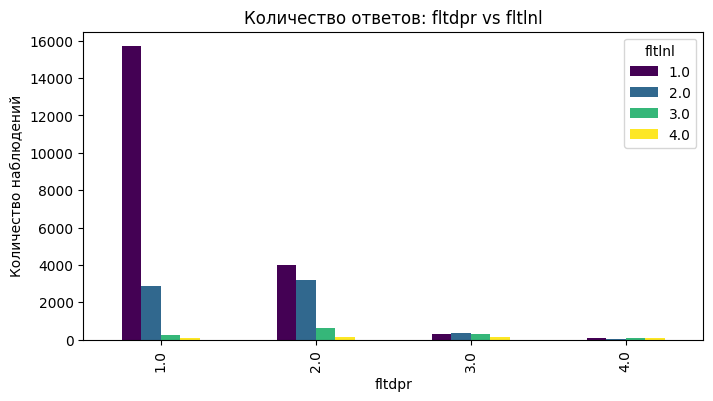

In [262]:
plt.figure(figsize=(10, 6))

pivot_data.plot(kind='bar', figsize=(8, 4), colormap='viridis')

plt.title("Количество ответов: fltdpr vs fltlnl")
plt.xlabel("fltdpr")
plt.ylabel("Количество наблюдений")
plt.legend(title='fltlnl')
plt.show()

Большинство ответов совпадает, но есть интересный момент - 115 человек, ответили что не чувствовали себя одинокими на прошлой неделе(1), но отвечая на 2 вопрос ответили, что почти всегда чувствовали себя одинокими(4), и наоборот 103 человека. Скорее всего лучше оставить один из признаков : fltdpr.

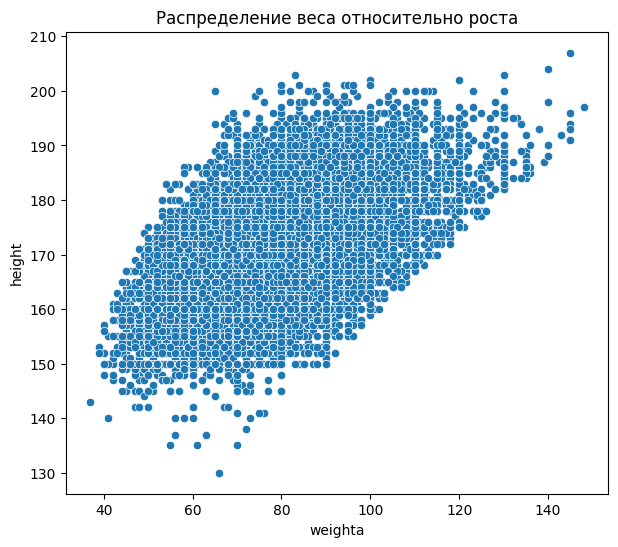

In [263]:
plt.figure(figsize = (7, 6))

sns.scatterplot(x=df_feat['weighta'], y=df_feat['height'])
plt.title('Распределение веса относительно роста')
plt.show()

Так как есть зависимость между ростом и весом, мы создадим новый признак индекс массы тела BMI, вычисляемый по формуле I= m/h*2,  m — масса тела в килограммах, h — рост в метрах.

Разделим на категории:

- 1 - 16 и менее (Выраженный дефицит массы тела)
- 2 - 16—18,5	(Недостаточная (дефицит) масса тела)
- 3 - 18,5—25	(Норма)
- 4 - 25—30	(Избыточная масса тела (предожирение))
- 5 - 30—35	(Ожирение 1 степени)
- 6 - 35—40	(Ожирение 2 степени)
- 7 - 40 и более	(Ожирение 3 степени)


In [264]:
data_20['bmi'] = data_20['weighta']/(data['height']/100)**2

bins = [0, 16, 18.5, 25, 30, 35, 40, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]
data_20['bmi_cat'] = pd.cut(data_20['bmi'], bins=bins, labels=labels, right=False)

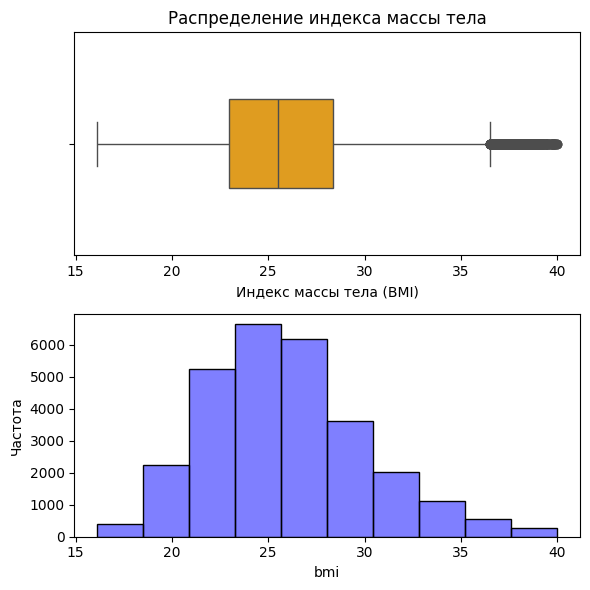

In [265]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))


sns.boxplot(x=data_20['bmi'], ax=ax[0], color='orange', width = 0.4)
ax[0].set_xlabel('Индекс массы тела (BMI)')
ax[0].set_title('Распределение индекса массы тела')

sns.histplot(data_20['bmi'], bins=10, color='blue', ax=ax[1], alpha=0.5)
ax[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [266]:
Q1 = data_20['bmi'].quantile(0.25)
Q3 = data_20['bmi'].quantile(0.75)
IQR = Q3 - Q1

# верхняя и нижние границы межквартильного размаха
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((data_20['bmi'] < lower_bound) | (data_20['bmi'] > upper_bound)).sum()
print(f'Верхняя граница: {upper_bound}')
print(f'Нижняя граница: {lower_bound}')
print(f'Количество выбросов: {outliers}, что составляет {round(outliers/data_20.shape[0]*100,2)}%')


Верхняя граница: 36.51208243852515
Нижняя граница: 14.809735728178971
Количество выбросов: 513, что составляет 1.81%


Большинство респондентов имеет нормальный и чуть выше среднего индекс массы тела. Признак 'bmi' имеет небольшое количество выбросов, поэтому чтобы не удалять данные, мы оставим только признак 'bmi_cat'.

In [267]:
# создадим новый бинарный признак физической активности, где 0 - нет занятий спортом и 1 - есть занятия спортом
data_20['dosprt_cat'] = data_20['dosprt'].apply(lambda x: 0 if x == 0 else 1)

# создадим новый бинарный признак отношения к курению, где 0 - не курит и 1 - курит
data_20['cgtsmok_cat'] = data_20['cgtsmok'].apply(lambda x: 0 if x in [4, 5, 6] else 1)

# создадим новый бинарный признак отношения к алкоголю, где 0 - не употребляет алкоголь и 1 - употребляет редко
data_20['alcfreq_cat'] = data_20['alcfreq'].apply(lambda x: 0 if x in [6,7] else 1)


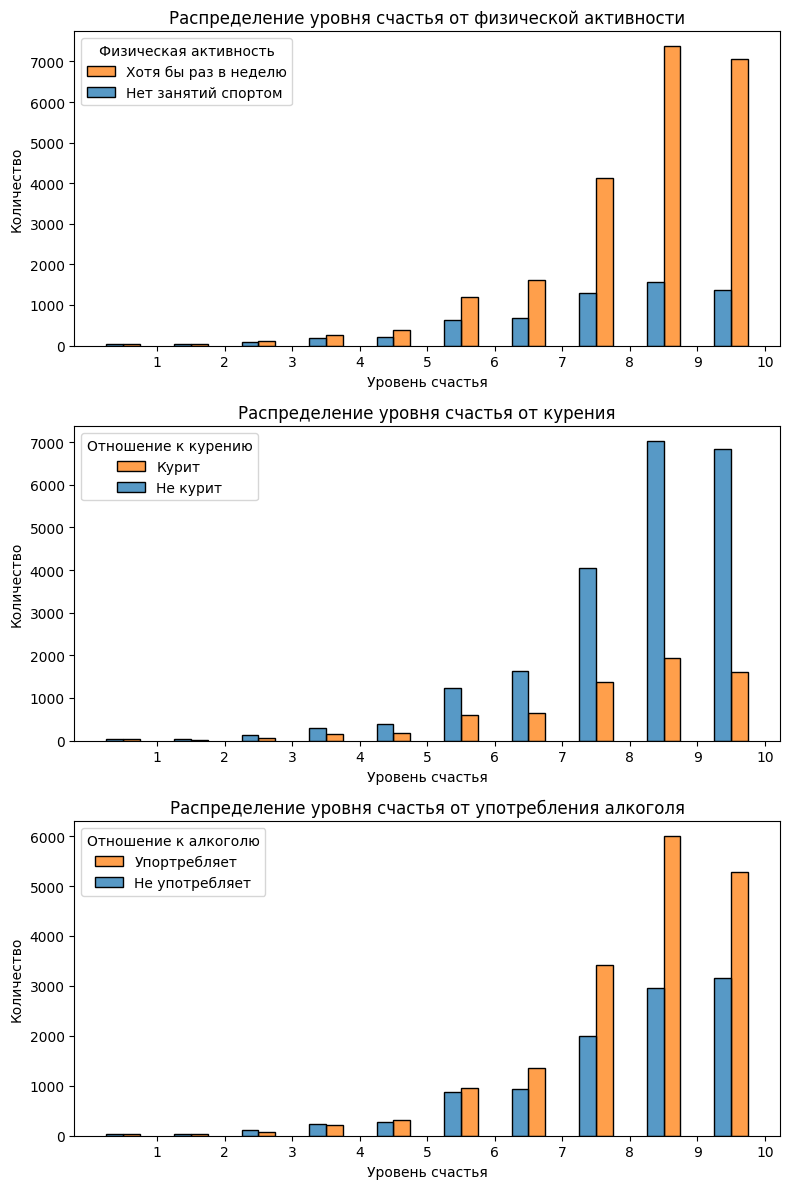

In [268]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

sns.histplot(data=data_20, x='happy', bins=10, hue='dosprt_cat', multiple="dodge",shrink=.5, ax=ax[0])
ax[0].set_title('Распределение уровня счастья от физической активности')
ax[0].set_xlabel('Уровень счастья')
ax[0].set_ylabel('Количество')
ax[0].set_xticks(np.arange(1, 11, 1))
ax[0].legend(title='Физическая активность', labels=[ 'Хотя бы раз в неделю', 'Нет занятий спортом'])


sns.histplot(data=data_20, x='happy', hue='cgtsmok_cat', bins=10, multiple="dodge",shrink=.5, ax=ax[1])
ax[1].set_title('Распределение уровня счастья от курения')
ax[1].set_xlabel('Уровень счастья')
ax[1].set_ylabel('Количество')
ax[1].set_xticks(np.arange(1, 11, 1))
ax[1].legend(title='Отношение к курению', labels=[ 'Курит', 'Не курит'])


sns.histplot(data=data_20, x='happy', hue='alcfreq_cat', bins=10, multiple="dodge",shrink=.5)
ax[2].set_title('Распределение уровня счастья от употребления алкоголя')
ax[2].set_xlabel('Уровень счастья')
ax[2].set_ylabel('Количество')
ax[2].set_xticks(np.arange(1, 11, 1))
ax[2].legend(title='Отношение к алкоголю', labels=[ 'Упортребляет', 'Не употребляет'])

plt.tight_layout()
plt.show()

Физическая активность и отказ от курения характерен для респондентов с более высоким уровнем счастья. С другой стороны, большее число респондентов с высоким уровнем счастья предпочитают употреблять алкоголь, чем те, кто отказывается от алкоголя.

In [269]:
columns_to_drop = ['fltlnl','weighta', 'height','alcfreq','bmi','cgtsmok','dosprt']

In [270]:
# построим матрицу корреляций
df_corr = data_20.drop(columns=['idno','cntry', 'yrbrn','weighta', 'height','alcfreq','bmi','cgtsmok','dosprt'], axis=1)
correlation_matrix = df_corr.corr(method='spearman')

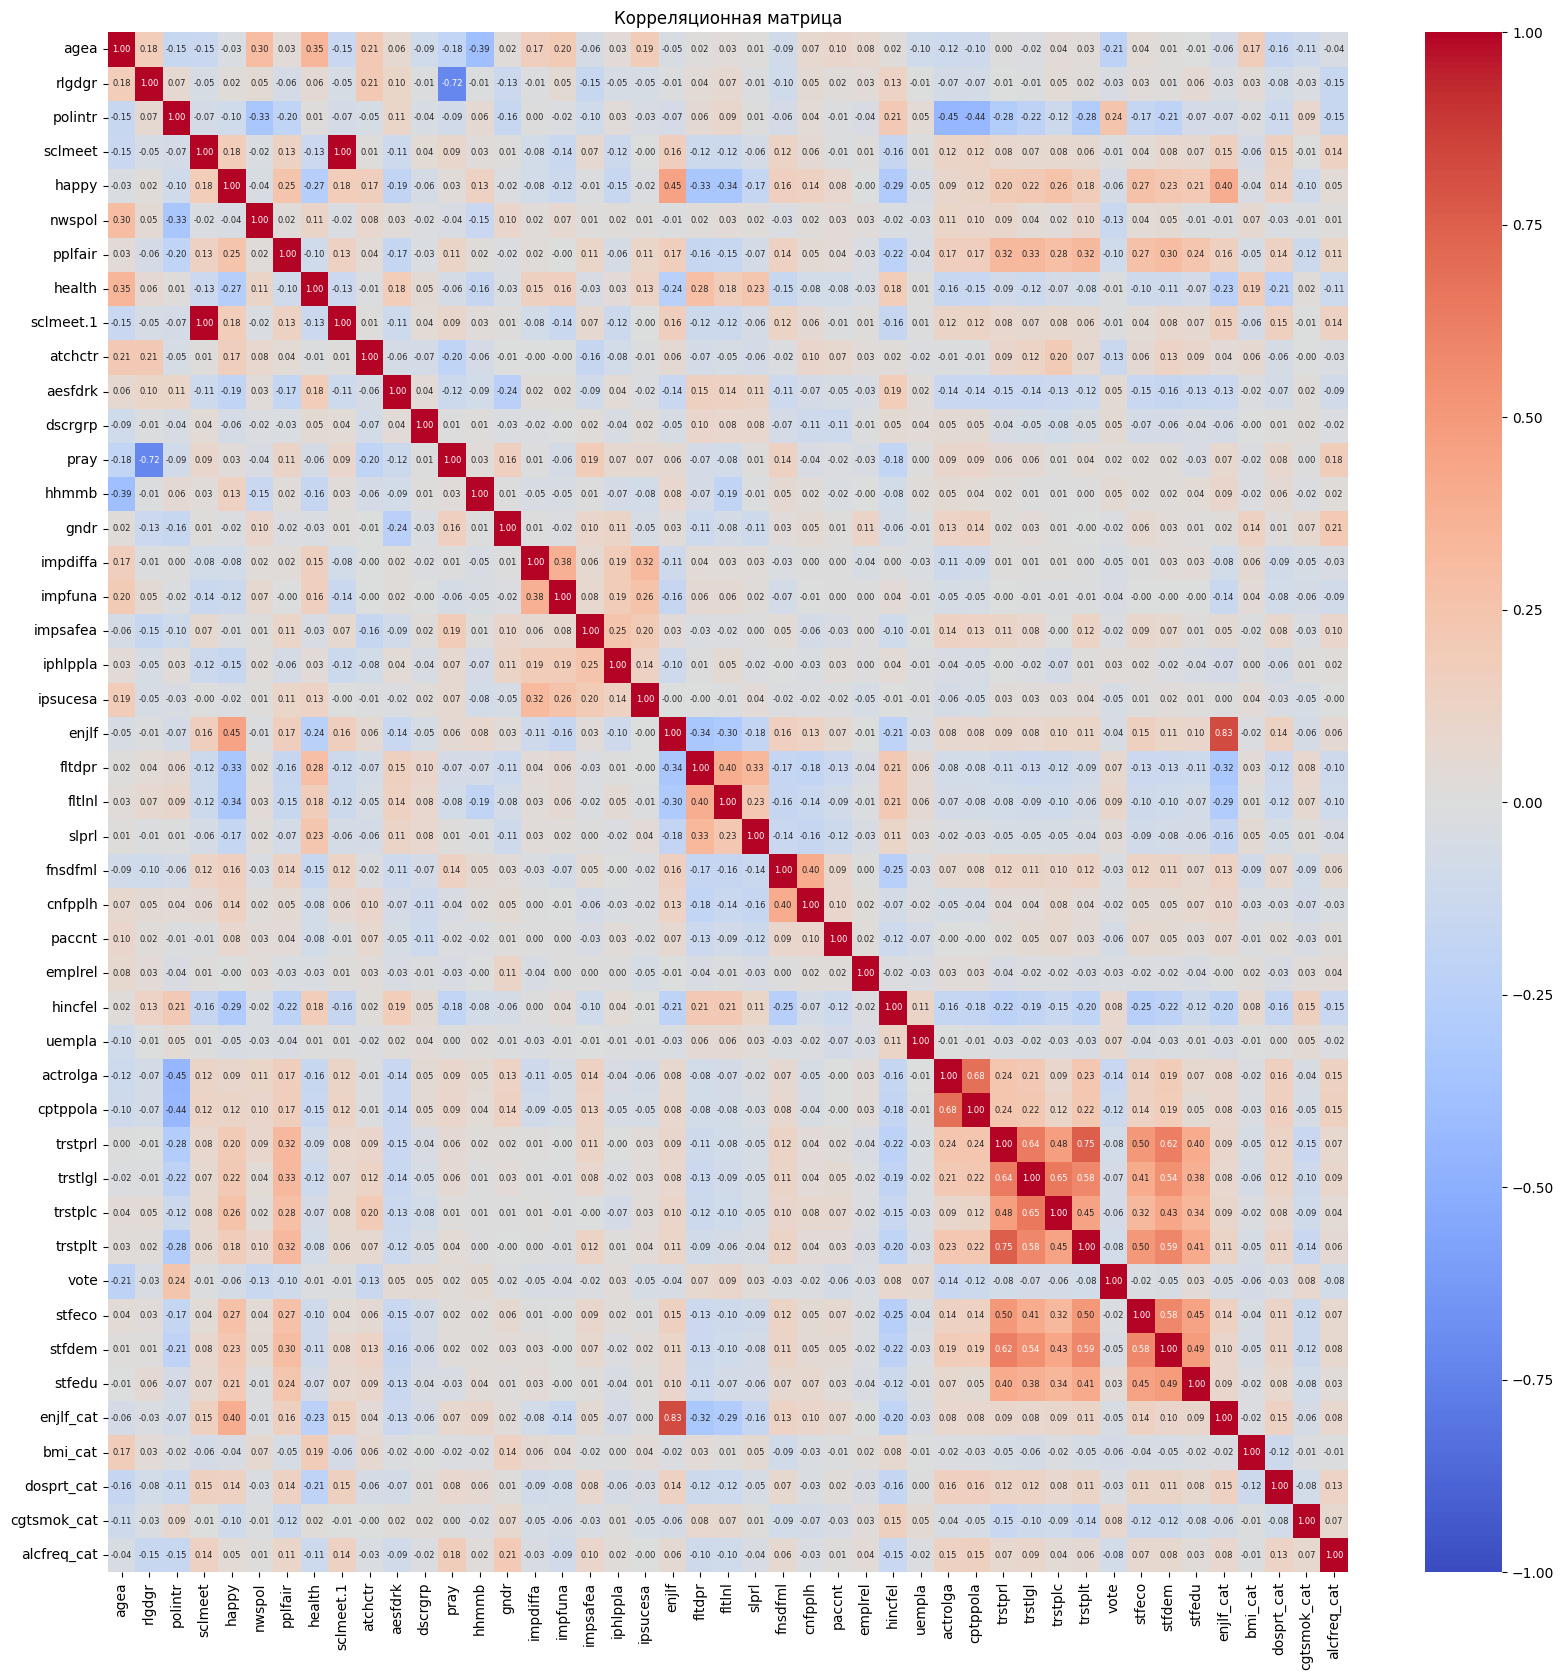

In [271]:
plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix , annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={'size':6})
plt.title("Корреляционная матрица")
plt.show()

In [272]:
# определяем порог значимой корреляции
threshold = 0.6
strong_correlation = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

# убираем дубликаты и NaN значения
strong_correlation = strong_correlation.dropna(how='all').dropna(axis=1, how='all')

In [273]:
strong_correlation_stacked = strong_correlation.stack().reset_index()
strong_correlation_stacked.columns = ['Feature_1', 'Feature_2', 'Correlation']
strong_correlation_stacked = strong_correlation_stacked[strong_correlation_stacked['Feature_1'] != strong_correlation_stacked['Feature_2']]

print("Пары признаков с высокой корреляцией:")
print(strong_correlation_stacked)

Пары признаков с высокой корреляцией:
    Feature_1  Feature_2  Correlation
2      rlgdgr       pray    -0.719130
5     sclmeet  sclmeet.1     1.000000
10  sclmeet.1    sclmeet     1.000000
15       pray     rlgdgr    -0.719130
25      enjlf  enjlf_cat     0.826728
36   actrolga   cptppola     0.684374
37   cptppola   actrolga     0.684374
40    trstprl    trstlgl     0.635583
41    trstprl    trstplt     0.754998
42    trstprl     stfdem     0.621645
43    trstlgl    trstprl     0.635583
45    trstlgl    trstplc     0.654244
46    trstplc    trstlgl     0.654244
48    trstplt    trstprl     0.754998
52     stfdem    trstprl     0.621645
55  enjlf_cat      enjlf     0.826728
